# Goal: Practical advice on how to code categorical variables in regressions
The goal of this notebook is demonstrate how to code categorical variables for use in regressions. There are many ways to code categorical variables, and they all lend themselves to different interpretations that can be useful under some circumstances. For this demo, I picked three default coding methods--dummy (treatment), one-hot, and helmert coding--and one custom coding method.

Note that all these methods will lead to the same predictions, but they will differ in how they affect regression coefficients and their standard errors: what the slope and s.e. mean, so what the test of that slope means for statistical decisions.  

**Main points:**  
1. Regression coefficients represent the effect of a one-unit change in the predictor on the target *when all other predictors equal 0.* This interpretation applies to continuous variables like age or income but also categorical variables like button color (e.g., grey = 0, blue = 1) or delivery status (e.g., delivered = -0.5, not delivered = 0.5). It affects how you interpret your intercept as well as how you interpret predictor effects within models with interaction/product terms (e.g, income x education).  
2. Multiplying two predictors together to create an interaction term (or a polynomial term) can change how one interprets those predictors compared to when they're in a model by themselves (i.e., without an interaction). This can have dramatic effects if one is multiplying one-hot or dummy (treatment) codes because multiplying by 0 results in 0.

**Practical Advice.** For similar reasons as those for mean-centering or standardizing predictors (0 = mean), code binary predictors with -0.5, 0.5 (effect codes) as a default. If you have more than two categories, consider helmert contrasts or polynomial contrasts as defaults simply because they guarantee that you can interpret your coefficients as unique slices of variance (i.e., reflects a comparison between groups that is independent of other comparisons in the model). These coding methods also guarantee that when you use them in product terms, you can still interpret their "main effects" (i.e., the effect of one factor) the same way as you did before including the interaction (because they're mean-centered). In contrast, dummy-coding or one-hot encoding *as defaults* introduce correlations between predictors and redundancy (i.e., comparing all groups to the same reference group which the user may not have selected). What's more, multiplying dummy/one-hot codes together to test interaction hypotheses affects how one interprets the predictors in the presence of an interaction.

**Resources.**
* [Linear Models: The Relation Between ANOVA and Regression](https://www.dropbox.com/s/l4fwymgta7qqibj/Designing_Experiments_and_Analyzing_Data_3rd__Tutorial_3.pdf?dl=1)  
* [Patsy: Contrast Coding Systems for categorical variables](https://www.statsmodels.org/devel/contrasts.html#user-defined-coding)

# Import packages and modules

In [1078]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn look
sns.set(palette = "colorblind")

# Generate example data

## True model
The idea here is that $\beta_0$ represents the grand mean and the remaining coefficients represent two binary factors ($\beta_1$ and $\beta_2$) and their interaction ($\beta_3$). Combined, the two binary factors represent 4 groups.

$Y_i = \beta_0 + \beta_1X_{1i} + \beta_2X_{2i} + \beta_3 (X_{1i} * X_{2i})$  

$Y_i = 3.5 + 0X_{1i} + 1X_{2i} + 1(X_{1i} *X_{2i})$

## Population parameters
4 means, 4 standard deviations, and 4 group sizes

In [1079]:
m = (3, 4, 4, 3)
s = (1, 1, 1, 1)
n = (10, 10, 10, 10)

## Draw random normal values from populations with population values

In [1080]:
# set random seed
np.random.seed(503748)

y = np.concatenate([np.random.normal(loc = i, scale = j, size = k) for (i, j, k) in zip(m, s, n)])

## Generate group variable that corresponds to values generated above

In [1081]:
# group combinations look like this
pd.DataFrame([["A-a", "A-b"], ["B-a", "B-b"]], columns = ["A", "a"], index = ["B", "b"])

,A,a
B,A-a,A-b
b,B-a,B-b


In [1082]:
# group combinations means look like this
pd.DataFrame([[3, 4], [4, 3]], columns = ["A", "a"], index = ["B", "b"])

,A,a
B,3,4
b,4,3


In [1083]:
# list repeat elements
group = np.repeat(["1", "2", "3", "4"], repeats = n)

# dictionary replace
factor1 = [{"1": "A", "2": "A", "3": "B", "4": "B"}[obs] for obs in group]
factor2 = [{"1": "a", "2": "b", "3": "a", "4": "b"}[obs] for obs in group]

## Store data in a data frame

In [1084]:
data_frame1 = pd.DataFrame({"y": y, "group": group, "factor1": factor1, "factor2": factor2})

# see it
data_frame1

,y,group,factor1,factor2
0,4.024368,1,A,a
1,1.906549,1,A,a
2,2.128628,1,A,a
3,2.437132,1,A,a
4,3.272201,1,A,a
5,2.929230,1,A,a
6,4.340647,1,A,a
7,3.534122,1,A,a
8,2.842423,1,A,a
9,1.951192,1,A,a


## Dummy codes (aka, treatment codes)

In [1085]:
print("Schema for the dummy/treatment comparisons")
pd.DataFrame(np.array([[1, 2, 3, 4], ["A", "A", "B", "B"], ["a", "b", "a", "b"], [1, 1, 1, 1], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]).transpose(), columns = ["group", "factor1", "factor2", "intercept", "g1Vg2", "g1Vg3", "g1Vg4"])

Schema for the dummy/treatment comparisons


,group,factor1,factor2,intercept,g1Vg2,g1Vg3,g1Vg4
0,1,A,a,1,0,0,0
1,2,A,b,1,1,0,0
2,3,B,a,1,0,1,0
3,4,B,b,1,0,0,1


In [1086]:
print("Full model matrix for the dummy/treatment comparisons")
dummy_matrix = patsy.dmatrix("C(group, Treatment)", data = data_frame1)

# see them
dummy_matrix[:, :]

Full model matrix for the dummy/treatment comparisons


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

In [1087]:
print("Dummy codes correlate with eachother, so their regression coefficients will not represent entirely unique variance explained.")
pd.DataFrame(dummy_matrix[:, 1:]).corr().round(2)

Dummy codes correlate with eachother, so their regression coefficients will not represent entirely unique variance explained.


,0,1,2
0,1.00,-0.33,-0.33
1,-0.33,1.00,-0.33
2,-0.33,-0.33,1.00


## One hot codes

In [1088]:
print("Schema for the one-hot code comparisons")
pd.DataFrame(np.array([[1, 2, 3, 4], ["A", "A", "B", "B"], ["a", "b", "a", "b"], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]).transpose(), columns = ["group", "factor1", "factor2", "g1", "g2", "g3", "g4"])

Schema for the one-hot code comparisons


,group,factor1,factor2,g1,g2,g3,g4
0,1,A,a,1,0,0,0
1,2,A,b,0,1,0,0
2,3,B,a,0,0,1,0
3,4,B,b,0,0,0,1


In [1089]:
print("Full model matrix for the one-hot comparisons")
onehot_matrix = pd.get_dummies(data_frame1["group"], drop_first = False).to_numpy()

# see them
onehot_matrix[:, :]

Full model matrix for the one-hot comparisons


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [1090]:
print("One hot codes correlate with eachother, so their regression coefficients will not represent entirely unique variance explained.")
pd.DataFrame(onehot_matrix[:, :]).corr().round(2)

One hot codes correlate with eachother, so their regression coefficients will not represent entirely unique variance explained.


,0,1,2,3
0,1.00,-0.33,-0.33,-0.33
1,-0.33,1.00,-0.33,-0.33
2,-0.33,-0.33,1.00,-0.33
3,-0.33,-0.33,-0.33,1.00


## Helmert codes

In [1091]:
print("Schema for the helmert comparisons")
pd.DataFrame(np.array([[1, 2, 3, 4], ["A", "A", "B", "B"], ["a", "b", "a", "b"], [1, 1, 1, 1], [-1, 1, 0, 0], [-1, -1, 2, 0], [-1, -1, -1, 3]]).transpose(), columns = ["group", "factor1", "factor2", "intercept", "g1Vg2", "g1and2Vg3", "g12and3Vg4"])

Schema for the helmert comparisons


,group,factor1,factor2,intercept,g1Vg2,g1and2Vg3,g12and3Vg4
0,1,A,a,1,-1,-1,-1
1,2,A,b,1,1,-1,-1
2,3,B,a,1,0,2,-1
3,4,B,b,1,0,0,3


In [1092]:
print("Full model matrix for the helmert comparisons")
helmert_matrix = patsy.dmatrix("C(group, Helmert)", data = data_frame1)

# see them
dummy_matrix[:, :]

Full model matrix for the helmert comparisons


array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 0., 1.]])

In [1093]:
print("Helmert codes do not correlate with eachother (i.e., they're orthogonal), so their regression coefficients will represent unique variance explained.")
pd.DataFrame(helmert_matrix[:, 1:]).corr().round(2)

Helmert codes do not correlate with eachother (i.e., they're orthogonal), so their regression coefficients will represent unique variance explained.


,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


## Custom codes

In [1094]:
print("Schema for the custom comparisons")
pd.DataFrame(np.array([[1, 2, 3, 4], ["A", "A", "B", "B"], ["a", "b", "a", "b"], [1, 1, 1, 1], [-1, -1, 1, 1], [-1, 1, -1, 1], [1, -1, -1, 1]]).transpose(), columns = ["group", "factor1", "factor2", "intercept", "AvB", "aVb", "interaction"])

Schema for the custom comparisons


,group,factor1,factor2,intercept,AvB,aVb,interaction
0,1,A,a,1,-1,-1,1
1,2,A,b,1,-1,1,-1
2,3,B,a,1,1,-1,-1
3,4,B,b,1,1,1,1


In [1095]:
print("Full model matrix for the custom comparisons")
custom_codes = patsy.contrasts.ContrastMatrix([[-1, -1, 1], [-1, 1, -1], [1, -1, -1], [1, 1, 1]], ["AvB", "aVb", "Interaction"])

# use to create matrix
custom_matrix = patsy.dmatrix("C(group, custom_codes)", data = data_frame1)

# see it
custom_matrix[:, :]

Full model matrix for the custom comparisons


array([[ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  

In [1096]:
print("These custom codes do not correlate with eachother (i.e., they're orthogonal), so their regression coefficients will represent unique variance explained.")
pd.DataFrame(custom_matrix[:, 1:]).corr().round(2)

These custom codes do not correlate with eachother (i.e., they're orthogonal), so their regression coefficients will represent unique variance explained.


,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


**Note.** Just because predictors are correlated with eachother doesn't mean their coefficients are uninterpretable.

## Add codes to date frame as predictors
I'll use these in regressions below.

In [1097]:
# add dummy codes
data_frame1["g1Vg2_dummy"] = dummy_matrix[:, 1]
data_frame1["g1Vg3_dummy"] = dummy_matrix[:, 2]
data_frame1["g1Vg4_dummy"] = dummy_matrix[:, 3]

# add one-hot codes
data_frame1["g1_onehot"] = onehot_matrix[:, 0]
data_frame1["g2_onehot"] = onehot_matrix[:, 1]
data_frame1["g3_onehot"] = onehot_matrix[:, 2]
data_frame1["g4_onehot"] = onehot_matrix[:, 3]

# add helmert codes
data_frame1["g1Vg2_helmert"] = helmert_matrix[:, 1]
data_frame1["g1and2V3_helmert"] = helmert_matrix[:, 2]
data_frame1["g12and3V4_helmert"] = helmert_matrix[:, 3]

# add custom codes
data_frame1["AvB_custom"] = custom_matrix[:, 1]
data_frame1["aVb_custom"] = custom_matrix[:, 2]
data_frame1["interaction_custom"] = custom_matrix[:, 3]

# see it
data_frame1

,y,group,factor1,factor2,g1Vg2_dummy,g1Vg3_dummy,g1Vg4_dummy,g1_onehot,g2_onehot,g3_onehot,g4_onehot,g1Vg2_helmert,g1and2V3_helmert,g12and3V4_helmert,AvB_custom,aVb_custom,interaction_custom
0,4.024368,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
1,1.906549,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
2,2.128628,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
3,2.437132,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
4,3.272201,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
5,2.929230,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
6,4.340647,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
7,3.534122,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
8,2.842423,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0
9,1.951192,1,A,a,0.0,0.0,0.0,1,0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


# Plot

## Violins

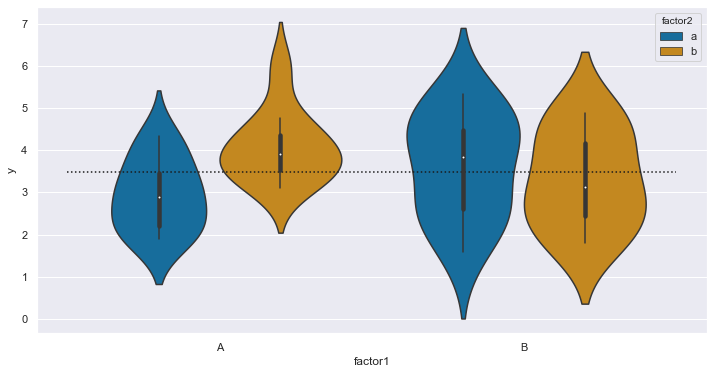

In [1098]:
# figure size
plt.figure(figsize = (12, 6))

# violins
sns.violinplot(x = "factor1", y = "y", hue = "factor2", data = data_frame1)

# grand mean
plt.hlines(y = np.mean(y), xmin = -0.5, xmax = 1.5, linestyles = "dotted");

## Means and bootstrapped 95% confidence intervals

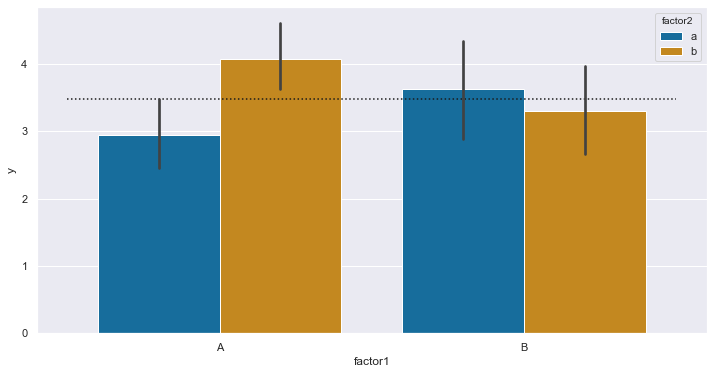

In [1099]:
# figure size
plt.figure(figsize = (12, 6))

# violins
sns.barplot(x = "factor1", y = "y", hue = "factor2", data = data_frame1)

# grand mean
plt.hlines(y = np.mean(y), xmin = -0.5, xmax = 1.5, linestyles = "dotted");

# Regressions

## Test custom contrasts
**Intercept** Grand mean  
**AvB** (Average of group A - average of group B) / 4  
**aVb** (Average of group a - average of group b) / 4  
**interaction** ((Average of group A and group b) - (average of group a and group B)) / 4

See below for quick computations of the coefficients based on group means

In [1100]:
# intercept
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 1, 1, 1)) / 4

3.4829329899600854

In [1101]:
# A vs. B
# weights should sum to 1, so divide by 4
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, -1, 1, 1)) / 4

-0.02183026732711557

In [1102]:
# a vs. b
# weights should sum to 1, so divide by 4
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 1, -1, 1)) / 4

0.2033742433746739

In [1103]:
# interaction
# weights should sum to 1, so divide by 4
np.dot(data_frame1.groupby("group")["y"].mean(), (1, -1, -1, 1)) / 4

-0.36473993999800713

In [1104]:
# OLS
smf.ols("y ~ AvB_custom + aVb_custom + interaction_custom", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:02   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              3.4829      0.164     21.243      0.000       3.150       3.815
AvB_custom            -0.0218      0.164     -0.133      0.895      -0.354       0.311
aVb_custom             0.2034      0.164      1.240      0.223      -0.129       0.536
interaction_custom    -0.3647      0.164     -2.225      0.032      -0.697      -0.032
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test dummy comparisons (aka, treatment contrasts)
**Intercept** Average of group 1   
**g1Vg2** Average of group 1 - average of group 2  
**g1Vg3** Average of group 1 - average of group 3    
**g1Vg4** Average of group 1 - average of group 4  

See below for quick computations of the coefficients based on group means

In [1105]:
# intercept
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 0, 0, 0))

2.93664907391452

In [1106]:
# group 1 vs. group 2
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 1, 0, 0))

1.136228366745362

In [1107]:
# group 1 vs. group 3
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 0, 1, 0))

0.6858193453417831

In [1108]:
# group 1 vs. group 4
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 0, 0, 1))

0.3630879520951167

In [1109]:
smf.ols("y ~ g1Vg2_dummy + g1Vg3_dummy + g1Vg4_dummy", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:02   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.9366      0.328      8.956      0.000       2.272       3.602
g1Vg2_dummy     1.1362      0.464      2.450      0.019       0.196       2.077
g1Vg3_dummy     0.6858      0.464      1.479      0.148      -0.255       1.626
g1Vg4_dummy     0.3631      0.464      0.783      0.439      -0.577       1.304
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         4.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test one hot comparisons
**NO INTERCEPT**  
**g1** Average of group 1  
**g2** Average of group 2   
**g3** Average of group 3   
**g4** Average of group 4 

See below for quick computations of the coefficients based on group means

In [1110]:
# group 1
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 0, 0, 0))

2.93664907391452

In [1111]:
# group 2
np.dot(data_frame1.groupby("group")["y"].mean(), (0, 1, 0, 0))

4.072877440659882

In [1112]:
# group 3
np.dot(data_frame1.groupby("group")["y"].mean(), (0, 0, 1, 0))

3.622468419256303

In [1113]:
# group 4
np.dot(data_frame1.groupby("group")["y"].mean(), (0, 0, 0, 1))

3.2997370260096366

In [1114]:
smf.ols("y ~ g1_onehot + g2_onehot + g3_onehot + g4_onehot - 1", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:02   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
g1_onehot      2.9366      0.328      8.956      0.000       2.272       3.602
g2_onehot      4.0729      0.328     12.421      0.000       3.408       4.738
g3_onehot      3.6225      0.328     11.047      0.000       2.957       4.288
g4_onehot      3.2997      0.328     10.063      0.000       2.635       3.965
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test helmert contrasts
**Intercept** Grand mean    
**g1Vg2** (Average of group 1 - average of group 2) / 2  
**g1and2Vg3** (Average of group 1 and 2 - average of group 3) / 6    
**g12and3Vg4** (Average of group 1, 2, and 3 - average of group 4) / 12  

See below for quick computations of the coefficients based on group means

In [1115]:
# intercept
# weights should sum to 1, so divide by 4
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 1, 1, 1)) / 4

3.4829329899600854

In [1116]:
# group 1 vs. group 2
# weights should sum to 1, so divide by 2
np.dot(data_frame1.groupby("group")["y"].mean(), (1, -1, 0, 0)) / 2

-0.568114183372681

In [1117]:
# group 1 and 2 vs. group 3
# weights should sum to 1, so divide by 6
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, -1, 2, 0)) / 6

0.039235053989700695

In [1118]:
# group 1, 2, and 3 vs. group 4
# weights should sum to 1, so divide by 12
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, -1, -1, 3)) / 12

-0.061065321316816336

In [1119]:
smf.ols("y ~ g1Vg2_helmert + g1and2V3_helmert + g12and3V4_helmert", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:02   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.4829      0.164     21.243      0.000       3.150       3.815
g1Vg2_helmert         0.5681      0.232      2.450      0.019       0.098       1.038
g1and2V3_helmert      0.0392      0.134      0.293      0.771      -0.232       0.311
g12and3V4_helmert    -0.0611      0.095     -0.645      0.523      -0.253       0.131
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         2.45
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Problems to look out for
Sometimes researchers are interested in interactions: the effect of one predictor depends on values of one or more other predictors. To test interaction hypotheses in a regression, one can simply compute the product of the predictor of interest and one or more "moderator" variables (i.e., other predictors moderate the effect of the predictor of interest). This product method works just fine in many circumstances, but the resulting product terms can have unexpected effects on how one interprets the effects of the component predictors by themselves. See a few examples below.

## Example 1: Multiply two binary effect codes (Absent = -0.5, Present = 0.5) to get their interaction

In [1120]:
# create variables
industry_experience = np.repeat(["Has no industry experience", "Has industry experience"], 2)
phd = np.tile(["Bachelor's degree only", "Has Ph.D."], 2)
industry_effect = np.repeat([-0.5, 0.5], 2)
phd_effect = np.tile([-0.5, 0.5], 2)

print("This coding method gives uncorrelated predictors that test single effects (the industry experience effect and the Ph.D. effect) and their interaction (e.g., the effect of industry experience could depend on having a Ph.D.)")
pd.DataFrame({"industry_experience": industry_experience, "phd": phd, "industry_effect": industry_effect, "phd_effect": phd_effect, "interaction": industry_effect * phd_effect})

This coding method gives uncorrelated predictors that test single effects (the industry experience effect and the Ph.D. effect) and their interaction (e.g., the effect of industry experience could depend on having a Ph.D.)


,industry_experience,phd,industry_effect,phd_effect,interaction
0,Has no industry experience,Bachelor's degree only,-0.5,-0.5,0.25
1,Has no industry experience,Has Ph.D.,-0.5,0.5,-0.25
2,Has industry experience,Bachelor's degree only,0.5,-0.5,-0.25
3,Has industry experience,Has Ph.D.,0.5,0.5,0.25


## Example 2: Multiply two binary one-hot codes (Absent = 0, Present = 1) to get their interaction

In [1121]:
# create variables
phd = np.tile(["Bachelor's degree only", "Has Ph.D."], 2)
industry_onehot = np.repeat([0, 1], 2)
phd_onehot = np.tile([0, 1], 2)

print("When coded correctly, this coding method gives uncorrelated predictors that test single effects (the industry experience effect and the Ph.D. effect) and their interaction (e.g., the effect of industry experience could depend on having a Ph.D.). But notice that multiplying the single predictors gives a potentially unintended product term: the first three groups get 0s and only the last group gets a 1. These msiplaced 0s and 1s will change the industry and Ph.D. effects (those predictors will now test different effects) but correctly test the interaction effect. I've added the correctly coded interaction as the final column. I'll explain more after running those regressions in a later section of this notebook.")
pd.DataFrame({"industry_experience": industry_experience, "phd": phd, "industry_effect": industry_onehot, "phd_effect": phd_onehot, "interaction_WRONG": industry_onehot * phd_onehot, "interaction": [0, 1, 1, 0]})

When coded correctly, this coding method gives uncorrelated predictors that test single effects (the industry experience effect and the Ph.D. effect) and their interaction (e.g., the effect of industry experience could depend on having a Ph.D.). But notice that multiplying the single predictors gives a potentially unintended product term: the first three groups get 0s and only the last group gets a 1. These msiplaced 0s and 1s will change the industry and Ph.D. effects (those predictors will now test different effects) but correctly test the interaction effect. I've added the correctly coded interaction as the final column. I'll explain more after running those regressions in a later section of this notebook.


,industry_experience,phd,industry_effect,phd_effect,interaction_WRONG,interaction
0,Has no industry experience,Bachelor's degree only,0,0,0,0
1,Has no industry experience,Has Ph.D.,0,1,0,1
2,Has industry experience,Bachelor's degree only,1,0,0,1
3,Has industry experience,Has Ph.D.,1,1,1,0


## Computing interactions from one hot codes

In [1122]:
data_frame1 = (data_frame1
               .assign(AvB_onehot = data_frame1["factor1"].replace({"A": 0, "B": 1}),
                       aVb_onehot = data_frame1["factor2"].replace({"a": 0, "b": 1}),
                       interaction_onehot = data_frame1["interaction_custom"].replace({-1: 1, 1: 0})))

# create interaction term the wrong way
data_frame1["interaction_onehot_WRONG"] = data_frame1["AvB_onehot"] * data_frame1["aVb_onehot"]

# see new columns
data_frame1[["factor1", "AvB_onehot", "factor2", "aVb_onehot", "interaction_onehot", "interaction_onehot_WRONG"]]

,factor1,AvB_onehot,factor2,aVb_onehot,interaction_onehot,interaction_onehot_WRONG
0,A,0,a,0,0.0,0
1,A,0,a,0,0.0,0
2,A,0,a,0,0.0,0
3,A,0,a,0,0.0,0
4,A,0,a,0,0.0,0
5,A,0,a,0,0.0,0
6,A,0,a,0,0.0,0
7,A,0,a,0,0.0,0
8,A,0,a,0,0.0,0
9,A,0,a,0,0.0,0


## Test unintended one-hot comparisons
**Intercept** Average of group 1  
**AvB** Average of group 3 - average of group 1 (NOT A vs. B like intended)  
**aVb** Average of group 2 - average of group 1 (NOT a vs. b like intended)  
**interaction** group 4 - group1 - (group 3 - group 1) - (group 2 -group 1) = group 4 + group 1 - group 2 - group 3 (interaction is intended but the way it was coded messed up the single factor comparisons)    

See below for quick computations of the coefficients based on group means

In [1123]:
# intercept
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 0, 0, 0))

2.93664907391452

In [1124]:
# AvB (not really -- that's what get's messed up here)
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 0, 1, 0))

0.6858193453417831

In [1125]:
# aVb (not really -- that's what get's messed up here)
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 1, 0, 0))

1.136228366745362

In [1126]:
# interaction (this is correct, but it messed up the interpretation of other effects)
np.dot(data_frame1.groupby("group")["y"].mean(), (1, -1, -1, 1))

-1.4589597599920285

In [1127]:
smf.ols("y ~ AvB_onehot + aVb_onehot + interaction_onehot_WRONG", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:03   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.9366      0.328      8.956      0.000       2.272       3.602
AvB_onehot                   0.6858      0.464      1.479      0.148      -0.255       1.626
aVb_onehot                   1.1362      0.464      2.450      0.019       0.196       2.077
interaction_onehot_WRONG    -1.4590      0.656     -2.225      0.032      -2.789      -0.129
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         6.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test intended one-hot comparisons
**Intercept** Average of group 1  
**AvB** (Average of group A - average of group B) / 4  
**aVb** (Average of group a - average of group b) / 4  
**interaction** ((Average of group A and group b) - (average of group a and group B)) / 4  

See below for quick computations of the coefficients based on group means

In [1128]:
# intercept
np.dot(data_frame1.groupby("group")["y"].mean(), (1, 0, 0, 0))

2.93664907391452

In [1129]:
# AvB
# weights should sum to 1, remember each set of dummy weights has two 0s and two 1s; the 1s sum to 2, so divide by 2
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, -1, 1, 1)) / 2

-0.04366053465423114

In [1130]:
# aVb
# weights should sum to 1, remember each set of dummy weights has two 0s and two 1s; the 1s sum to 2, so divide by 2
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 1, -1, 1)) / 2

0.4067484867493478

In [1131]:
# aVb
# weights should sum to 1, remember each set of dummy weights has two 0s and two 1s; the 1s sum to 2, so divide by 2
np.dot(data_frame1.groupby("group")["y"].mean(), (-1, 1, 1, -1)) / 2

0.7294798799960143

In [1132]:
smf.ols("y ~ AvB_onehot + aVb_onehot + interaction_onehot", data = data_frame1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     2.168
Date:                Fri, 03 Jul 2020   Prob (F-statistic):              0.109
Time:                        21:06:03   Log-Likelihood:                -56.102
No. Observations:                  40   AIC:                             120.2
Df Residuals:                      36   BIC:                             127.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9366      0.328      8.956      0.000       2.272       3.602
AvB_onehot            -0.0437      0.328     -0.133      0.895      -0.709       0.621
aVb_onehot             0.4067      0.328      1.240      0.223      -0.258       1.072
interaction_onehot     0.7295      0.328      2.225      0.032       0.064       1.395
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   2.576
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                1.394
Skew:                           0.157   Prob(JB):                        0.498
Kurtosis:                       2.141   Cond. No.                         3.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# All these coding methods give the same model predictions
In other words, coefficients can be very different but model error is the same.

## Save residuals from each model

In [1133]:
model_fit = {}

for formula in ["y ~ AvB_custom + aVb_custom + interaction_custom", "y ~ g1Vg2_dummy + g1Vg3_dummy + g1Vg4_dummy", "y ~ g1_onehot + g2_onehot + g3_onehot + g4_onehot - 1", "y ~ g1Vg2_helmert + g1and2V3_helmert + g12and3V4_helmert", "y ~ AvB_onehot + aVb_onehot + interaction_onehot_WRONG", "y ~ AvB_onehot + aVb_onehot + interaction_onehot"]:
    model_fit[formula] = smf.ols(formula, data = data_frame1).fit()

## Plot residuals

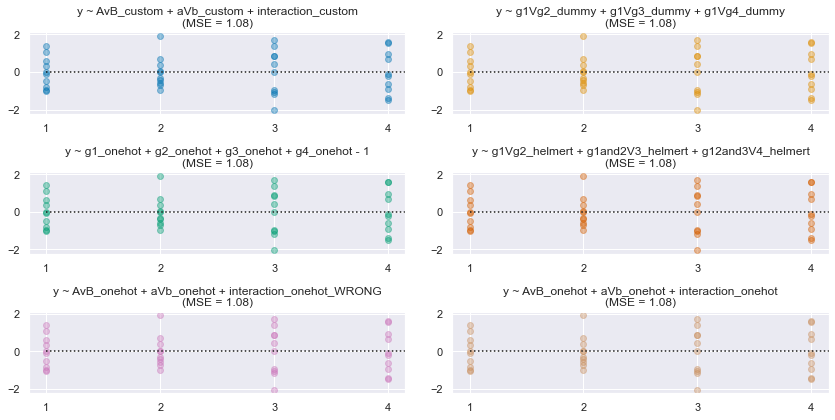

In [1134]:
# figure
fig, ax = plt.subplots(3, 2, figsize = (12, 6))

for i, (formula, fit) in enumerate(model_fit.items()):
    # title
    ax.flatten()[i].set_title(formula + "\n(MSE = {})".format(np.round(fit.mse_resid, 2)))
    
    # hline at 0
    ax.flatten()[i].hlines(y = 0, xmin = 0, xmax = 4, linestyles = "dotted")
    
    # scatterplot
    ax.flatten()[i].scatter(group, fit.resid, color = sns.color_palette()[i], alpha = 0.40)

# fix plot
fig.tight_layout()